## This is a sample notebook to identify patient's medical conditions and ICD-10 codes from the patient notes.

There are <b>4 different options</b> shown to extract the patient's medical conditions and ICD-10 codes from the patient notes:
- <b>Option 1:</b> one can share the patient notes and use prompt engineering with LLM to extract the patient's medical conditions and ICD-10 codes
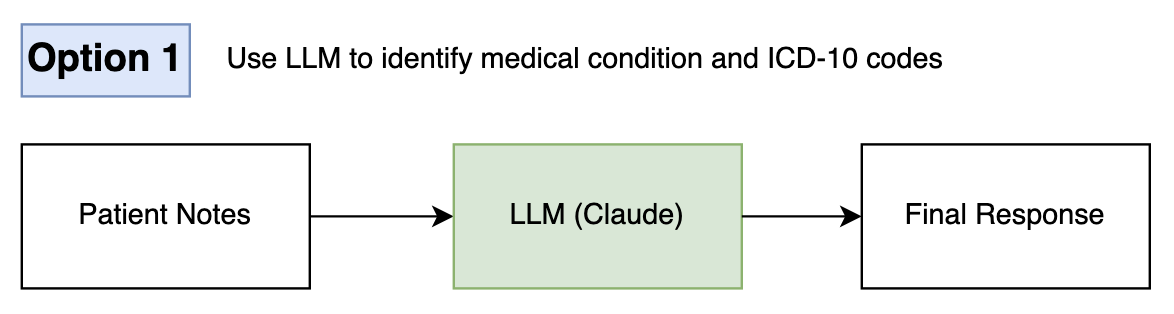

- <b>Option 2:</b> one can use Amazon Comprehend Medical to extract an initial set of recommednation on the patient's medical conditions and ICD-10 codes from the patient notes. Then use that as an input to LLM and fine tune the response on the patient's medical conditions and ICD-10 codes
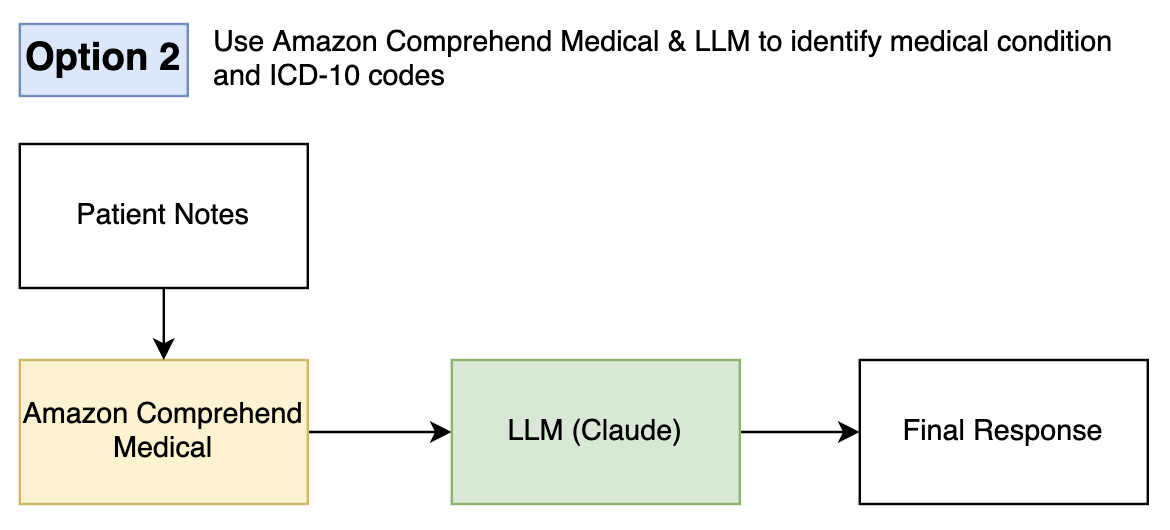

- <b>Option 3:</b> one can use LLM to extract an initial set of recommednation on the patient's medical conditions and ICD-10 codes from the patient notes. Then use organization's guidlines from the internal Knowledge Base (KB) to find any nuances on the ICD-10 codes based on the medical conditions. Finally use the initial set of recommendations and the KB input to fine tune the response on the patient's medical conditions and ICD-10 codes
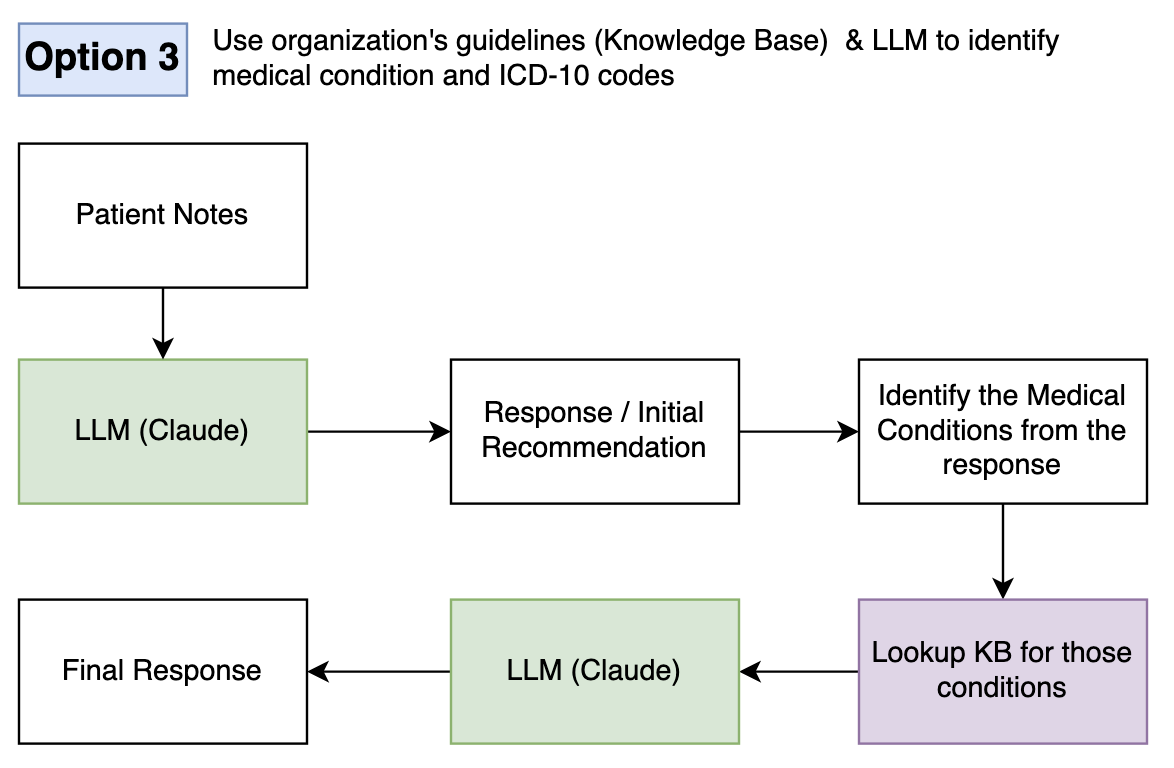

- <b>Option 4:</b> one can use Amazon Comprehend Medical to extract an initial set of recommednation on the patient's medical conditions and ICD-10 codes from the patient notes. Then use that as an input to LLM and fine tune the response on the patient's medical conditions and ICD-10 codes. This can further be enhanced by looking up the organization's guidlines from the internal Knowledge Base (KB) to find any nuances on the ICD-10 codes based on the identified medical conditions. Finally use the initial set of recommendations and the KB input to get the response on the patient's medical conditions and ICD-10 codes
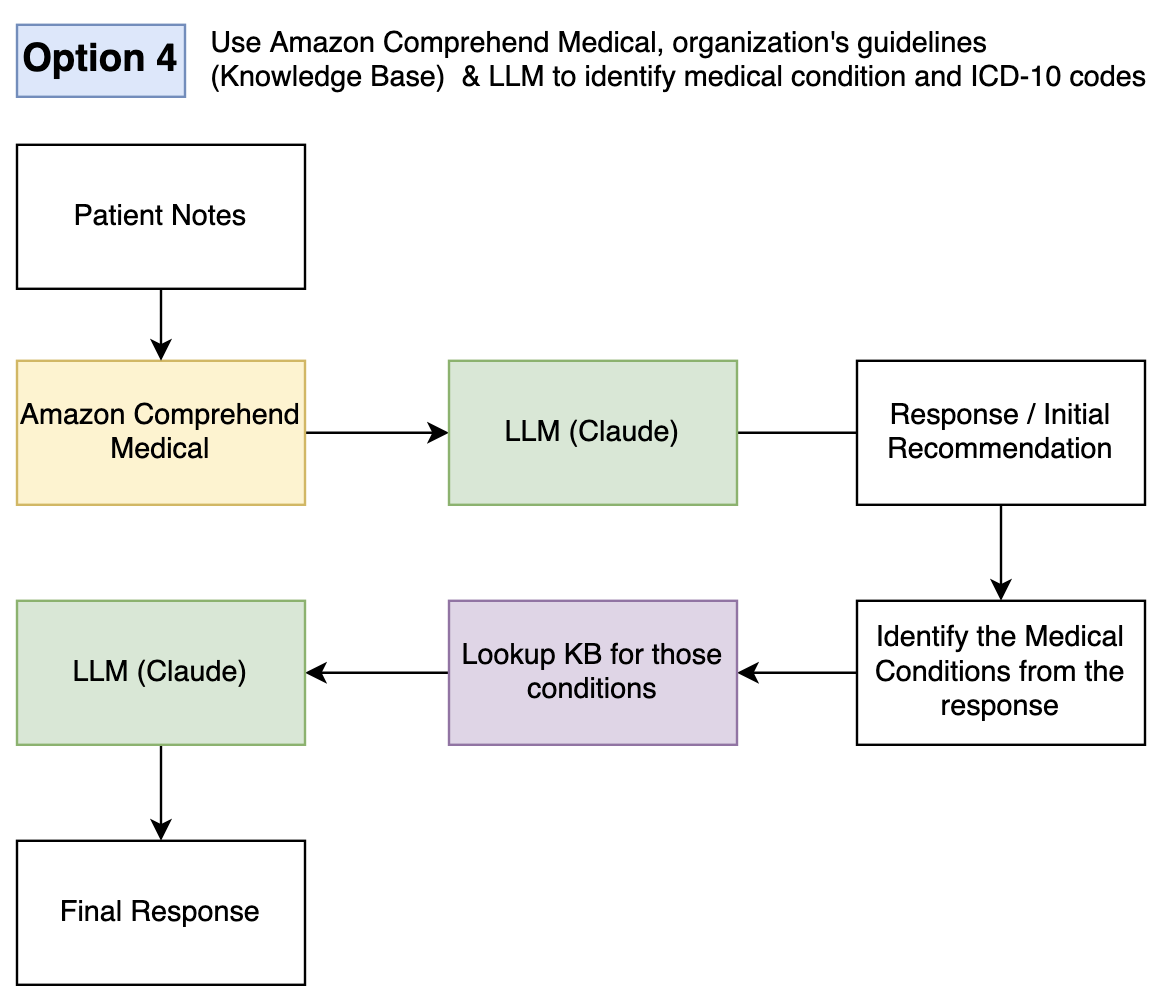

<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
## Install latest packages

<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>

In [1]:
%pip install --upgrade pip
%pip install boto3==1.34.138 --force-reinstall --quiet
%pip install botocore==1.34.139 --force-reinstall --quiet

Note: you may need to restart the kernel to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 1.1.1 requires nvidia-ml-py3==7.352.0, which is not installed.
aiobotocore 2.13.2 requires botocore<1.34.132,>=1.34.70, but you have botocore 1.34.162 which is incompatible.
amazon-sagemaker-sql-magic 0.1.3 requires sqlparse==0.5.0, but you have sqlparse 0.5.1 which is incompatible.
autogluon-core 1.1.1 requires scikit-learn<1.4.1,>=1.3.0, but you have scikit-learn 1.4.2 which is incompatible.
autogluon-features 1.1.1 requires scikit-learn<1.4.1,>=1.3.0, but you have scikit-learn 1.4.2 which is incompatible.
autogluon-multimodal 1.1.1 requires omegaconf<2.3.0,>=2.1.1, but you have omegaconf 2.3.0 which is incompatible.
autogluon-multimodal 1.1.1 requires scikit-learn<1.4.1,>=1.3.0, but you have scikit-learn 1.4.2 which is incomp

<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
## Import libraries, declare global variables 

<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>

In [1]:
import boto3
import json
import re
from botocore.client import Config
from botocore.exceptions import ClientError

region = 'us-east-1'
model_id = 'anthropic.claude-3-sonnet-20240229-v1:0'

s3_bucket = '' ## bucket name where you are uploading the patient's note. The CDK deployment will create S3 bucket for use usage. You can get bucket name from AWS S3 console. 
s3_input_object_key = 'gen-ai/icd-10/input/patient_note.json'
s3_output_object_key = 'gen-ai/icd-10/output/patient_medical_conditions.json'

use_comprehend_medical = 'Y'
cm_threshold = 0.70
use_knowledge_base = 'Y'
kb_id = '' ## Bedrock Knowledgebase ID. The CDK deployment will create bedrock knowledge base. You can get knowledge base ID from AWS Bedrock console. 
kb_number_of_results = 5


<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
## Setup Bedrock client and define the function

<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>

In [2]:
bedrock_client = boto3.client(service_name='bedrock-runtime', region_name=region)
bedrock_config = Config(connect_timeout=120, read_timeout=120, retries={'max_attempts': 0})
bedrock_agent_client = boto3.client("bedrock-agent-runtime",
                              config=bedrock_config, region_name = region)

def get_completion(prompt, system_prompt=None, prefill=None):
    inference_config = {
        "temperature": 0.0,
         "maxTokens": 4096
    }
    converse_api_params = {
        "modelId": model_id,
        "messages": [{"role": "user", "content": [{"text": prompt}]}],
        "inferenceConfig": inference_config
    }
    if system_prompt:
        converse_api_params["system"] = [{"text": system_prompt}]
    if prefill:
        converse_api_params["messages"].append({"role": "assistant", "content": [{"text": prefill}]})
    try:
        response = bedrock_client.converse(**converse_api_params)
        text_content = response['output']['message']['content'][0]['text']
        # Print token usage.
        token_usage = response['usage']
        print("Input tokens: %s", token_usage['inputTokens'])
        print("Output tokens: %s", token_usage['outputTokens'])
        print("Total tokens: %s", token_usage['totalTokens'])
        print("Stop reason: %s", response['stopReason'])
        return text_content

    except ClientError as err:
        message = err.response['Error']['Message']
        print(f"A client error occured: {message}")

<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
## Patient Notes

<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>

In [3]:
s3_client =boto3.client('s3')
s3_clientobj = s3_client.get_object(Bucket=s3_bucket, Key=s3_input_object_key)
s3_clientdata = s3_clientobj['Body'].read().decode('utf-8')

patient_notes = s3_clientdata

print("----------------------------")
print("------ Patient Notes: ------")
print("----------------------------")
print(patient_notes)

----------------------------
------ Patient Notes: ------
----------------------------
{
  "name": "Patient 1",
  "age": "57 years",
  "sex": "Male",
  "encounters": [
    {
      "Date": "2016-01-21",
      "ICD10 diagnoses": "R01.1",
      "Procedure codes": "93306",
      "note": []
    },
    {
      "Date": "2016-02-25",
      "Lab results": "potassium: 4 mmol/L, Body temperature: 97 degree Fahrenheit, Hemoglobin A1c/Hemoglobin.total in Blood: 5%, HDL cholesterol: 73 mg/dL, glucose: 103 mg/dL, albumin/globulin ratio: 2 (calc), Oxygen saturation: 98 percent, Respiratory rate: 18 Breaths / minute, creatinine: 1 mg/dL, ALT: 21 U/L, Body weight: 112037 gram, globulin: 2 g/dL (calc), carbon dioxide: 25 mmol/L, Body mass index (BMI): 40 kilogram / (meter ^ 2), alkaline phosphatase: 77 U/L, estimated avg. glucose: 108 mg/dL (calc), chloride: 102 mmol/L, blood urea nitrogen: 19 mg/dL, bilirubin, total: 1 mg/dL, GFR non-african american: 78 , triglycerides: 111 mg/dL, BUN/creatinine ratio:

<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
## Call Comprehend Medical

<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>

In [4]:
if use_comprehend_medical == 'Y':
    comprehend_med = boto3.client('comprehendmedical')

    cm_response = comprehend_med.infer_icd10_cm(
        Text = patient_notes
    )
    print("--------------------------")
    print("------ CM Response: ------")
    print("--------------------------")
    print(cm_response)

    cm_output = []

    response_entities = cm_response["Entities"]
    for entity in response_entities:
        cm_text = entity["Text"]
        cm_category = entity["Category"]
        cm_icd10concepts = entity["ICD10CMConcepts"]

        cm_icd10concepts_above_threshold_score = []

        inclusion_flag = "N" 

        for cm_icd10concept in cm_icd10concepts:
            if cm_icd10concept["Score"] >= cm_threshold:
                inclusion_flag = "Y"
                cm_icd10concepts_above_threshold_score.append({
                    'cm_icd10concept' : cm_icd10concept
                })

        if inclusion_flag == "Y":
            cm_output.append({
                'cm_text': cm_text,
                'cm_category': cm_category,
                'cm_icd10concepts_above_threshold_score' : cm_icd10concepts_above_threshold_score
            })
            
    print("\n\n")
    print("---------------------------------------------------------------------")
    print("------ CM Output: Entities with score above than the threshold ------")
    print("---------------------------------------------------------------------")
    print(cm_output)
    cm_output_str = json.dumps(cm_output)

--------------------------
------ CM Response: ------
--------------------------
{'Entities': [{'Id': 117, 'Text': 'Stable', 'Category': 'MEDICAL_CONDITION', 'Type': 'DX_NAME', 'Score': 0.877546489238739, 'BeginOffset': 1688, 'EndOffset': 1694, 'Attributes': [], 'Traits': [{'Name': 'SIGN', 'Score': 0.7299559712409973}], 'ICD10CMConcepts': [{'Description': 'Other general symptoms and signs', 'Code': 'R68.89', 'Score': 0.0384138785302639}, {'Description': 'Finding of steroid agent in blood', 'Code': 'R78.6', 'Score': 0.029319066554307938}, {'Description': 'Other serum reactions', 'Code': 'T80.6', 'Score': 0.024561259895563126}, {'Description': 'Findings of drugs and other substances, not normally found in blood', 'Code': 'R78', 'Score': 0.023703327402472496}, {'Description': 'Encounter for therapeutic drug level monitoring', 'Code': 'Z51.81', 'Score': 0.022971119731664658}]}, {'Id': 326, 'Text': '25 pounds increased', 'Category': 'MEDICAL_CONDITION', 'Type': 'DX_NAME', 'Score': 0.6603351

<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
## Prompt Template:

This is the base prompt template that has been broken down into multiple segments based on the prompt engineering [best practices](https://docs.anthropic.com/claude/docs/prompt-engineering) suggested by Anthropic.

<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>

In [5]:
######################################## INPUT VARIABLES ########################################

# First input variable - the conversation history (this can also be added as preceding `user` and `assistant` messages in the API call)
HISTORY = ""

# Second input variable - the user's question
QUESTION = "Share your recommendation about the medical conditions of the patient"



######################################## PROMPT ELEMENTS ########################################

##### Prompt element 1: `user` role
# Make sure that your Messages API call always starts with a `user` role in the messages array.
# The get_completion() function as defined above will automatically do this for you.

##### Prompt element 2: Task context
# Give Claude context about the role it should take on or what goals and overarching tasks you want it to undertake with the prompt.
# It's best to put context early in the body of the prompt.
TASK_CONTEXT = "You are a medical reviewer. You review patient notes and provide recommendation to the doctor about the medical conditions of the patient. Your recommendation includes patient’s current and chronic medical conditions. Your recommendation helps the doctor to decide on the treatment plan."

##### Prompt element 3: Tone context
# If important to the interaction, tell Claude what tone it should use.
# This element may not be necessary depending on the task.
TONE_CONTEXT = "You should maintain a friendly customer service tone."

##### Prompt element 4: Detailed task description and rules
# Expand on the specific tasks you want Claude to do, as well as any rules that Claude might have to follow.
# This is also where you can give Claude an "out" if it doesn't have an answer or doesn't know.
# It's ideal to show this description and rules to a friend to make sure it is laid out logically and that any ambiguous words are clearly defined.

TASK_DESCRIPTION = """Here are some important rules for the interaction:

- Refer to the <patient_notes>. Carefully read through the history, medications, encounters. For each encounter, carefully review the lab results, note. Check line-by-line to look for any evidence of medical conditions. 

- Lab results contain comma separated list of lab readings, which can be lengthy. Please read through each and every value carefully. Maintain a list of common lab value thresholds that indicate potential conditions, and cross-check any out-of-range values against this list. 

- When reviewing notes, actively look for any mention of symptoms, diagnoses, medications prescribed, or procedures done that could indicate a condition. Only list a medical condition when you see clear evidence in the lab results or notes to support a diagnosis. 

$cm_instruction$

- Please do not make any assumptions without verifying supporting evidence for the specific date.

- For each date, list all the medical conditions, corresponding ICD 10 codes, relevant explanation as evidence.

- Only use the information provided to generate the recommendation. If there are no medical condition to recommend to the doctor tell no medical condition to report.

- Provide the final recommendation inside <recommendation></recommendation> XML tags in JSON format, with each condition formatted as:
{
  "Active_Condition":[
  {"Review": {  
  "DX_Code": "ICD10 Code",
  "Description": "Condition description",
  "Memo": {
              "date":"date",
              "note":"Explanation from notes"
          }
  }},
  {"Review": {
  "DX_Code": "ICD10 Code",
  "Description": "Condition description",
  "Memo": {
              "date":"date",
              "note":"Explanation from notes"
          }
  }}],
  "Inactive_Condition": [
    {"Review": {
      "DX_Code": "ICD10 Code",
      "Description": "Condition description",
      "Memo": {
        "date": "date",
        "note": "Explanation from notes"
      }
  }}]
}
"""

cm_instruction = ""
if use_comprehend_medical == 'Y':
    cm_instruction = "- Refer to the findings from comprehend medical inside <comprehend_medical></comprehend_medical> XML tag. Use this as a helper tool to identify the medical conditions."
TASK_DESCRIPTION = TASK_DESCRIPTION.replace("$cm_instruction$",cm_instruction)

##### Prompt element 5: Examples
# Provide Claude with at least one example of an ideal response that it can emulate. Encase this in <example></example> XML tags. Feel free to provide multiple examples.
# If you do provide multiple examples, give Claude context about what it is an example of, and enclose each example in its own set of XML tags.
# Examples are probably the single most effective tool in knowledge work for getting Claude to behave as desired.
# Make sure to give Claude examples of common edge cases. If your prompt uses a scratchpad, it's effective to give examples of how the scratchpad should look.
# Generally more examples = better.
EXAMPLES = """Here is an example inside <example></example> XML tag on how to perform the task: 
<example>
user: <patient_notes>
{
  "name": "XYZ",
  "age": "60 years",
  "sex": "Male",
  "encounters": [ 
    {
      "Date": "2022-01-04", 
      "Procedure codes": "99214",
      "note": ["Blood pressure has been stable. Pt is overdue for physical and labs. Pt will come to the lab next month and will schedule an appointment for a physical.", "stable"]
    },
    {
      "Date": "2022-02-04", 
      "note": ["Dual-chamber pacemaker was placed for sinus node dysfunction."]
    },
    {
      "Date": "2023-07-22",
      "note": ["Had unprovoked PE.  Still on anticoagulation.  Oncology note dated 07/05/2023: long term anticoagulation recommended.  It can be primary hypercoagulability."]
    }, 
    {
      "Date": "2023-07-31", 
      "note": ["Patient visited XXX DPM. Came in for foot care, upon neurology foot examination revealed reduced monofilament test and spontaneous. Suggested evaluation for Type 2 diabetes mellitus with diabetic polyneuropathy.", "Patient visited doctor for cough, chest soreness, runny nose, headache, slight fever, and sore throat. Doctor suggested to take Ibuprofen and cough suppressant"]
    }
  ]
}
</patient_notes>

assistant: <response>
<thinking>
Date: 2022-01-04
No evidence of medical conditions

Date: 2022-02-04
Condition: Sinus node dysfunction 
ICD10: I49.5
Evidence: Dual-chamber pacemaker was placed for sinus node dysfunction.

Date: 2023-07-22  
Condition: Pulmonary embolism
ICD10: I26.99
Evidence: Had unprovoked PE. Still on anticoagulation. Oncology note dated 07/05/2023: long term anticoagulation recommended. It can be primary hypercoagulability.

Date: 2023-07-31
Condition 1: Type 2 diabetes mellitus with diabetic polyneuropathy
ICD10: E11.42
Evidence: Patient visited XXX DPM. Came in for foot care, upon neurology foot examination revealed reduced monofilament test and spontaneous. Suggested evaluation for Type 2 diabetes mellitus with diabetic polyneuropathy.

Condition 2: Upper respiratory infection 
ICD10: J06.9
Evidence: Patient visited doctor for cough, chest soreness, runny nose, headache, slight fever, and sore throat. Doctor suggested to take Ibuprofen and cough suppressant.

Date: 2023-09-01
Condition 1: Vitamin D deficiency
ICD10: E55.9
Evidence: vitamin D 25-oh, total: 43 NG/mL

Condition 2: Upper respiratory infection (inactive)
ICD10: J06.9
Evidence: Doctor visit. Patient no longer complained of cough. Patient is not taking Ibuprofen and cough suppressant anymore.

Inactive Conditions:
- Upper respiratory infection (J06.9)

Active Conditions:  
- Sinus node dysfunction (I49.5)
- Pulmonary embolism (I26.99)
- Type 2 diabetes mellitus with diabetic polyneuropathy (E11.42)
- Prostate cancer (C61)
- Vitamin D deficiency (E55.9)
</thinking>

<recommendation>
{
  "Active_Condition": [ 
  {"Review":{
    "DX_Code": "I49.5",  
    "Description": "Sinus node dysfunction",
    "Memo": {
      "date": "2022-02-04",
      "note": "Dual-chamber pacemaker was placed for sinus node dysfunction."
    }
  }},  
  {"Review": {  
    "DX_Code": "I26.99",
    "Description": "Pulmonary embolism", 
    "Memo": {
      "date": "2023-07-22",  
      "note": "Had unprovoked PE. Still on anticoagulation. Oncology note dated 07/05/2023: long term anticoagulation recommended. It can be primary hypercoagulability."
    }
  }},
  {"Review": {
    "DX_Code": "E11.42",  
    "Description": "Type 2 diabetes mellitus with diabetic polyneuropathy",
    "Memo": {
      "date": "2023-07-31",
      "note": "Patient visited XXX DPM. Came in for foot care, upon neurology foot examination revealed reduced monofilament test and spontaneous. Suggested evaluation for Type 2 diabetes mellitus with diabetic polyneuropathy."
    }
  }},
  {"Review": {
    "DX_Code": "E55.9",
    "Description": "Vitamin D deficiency",  
    "Memo": {
        "date": "2023-09-01",
        "note": "vitamin D 25-oh, total: 43 NG/mL"
      }
    }}],
  "Inactive_Condition": [
    {"Review": {
      "DX_Code": "J06.9",
      "Description": "Upper respiratory infection",
      "Memo": {
        "date": "2023-09-01",
        "note": "Doctor visit. Patient no longer complained of cough. Patient is not taking Ibuprofen and cough suppressant anymore."
      }
    }}]
  }
</recommendation>
</response>
</example>"""

##### Prompt element 6: Input data to process
# If there is data that Claude needs to process within the prompt, include it here within relevant XML tags.
# Feel free to include multiple pieces of data, but be sure to enclose each in its own set of XML tags.
# This element may not be necessary depending on task. Ordering is also flexible.

INPUT_DATA = f"""Here are the patient notes: 
<patient_notes>
{patient_notes}
</patient_notes>

$cm_context$

Here is the user's question:
<question>
{QUESTION}
</question>"""

cm_context = ""
if use_comprehend_medical == 'Y':
    cm_context = f"""Here are the comprehend medical findings:
    <comprehend_medical> 
    {cm_output_str} 
    </comprehend_medical>"""
INPUT_DATA = INPUT_DATA.replace("$cm_context$",cm_context)

##### Prompt element 7: Immediate task description or request #####
# "Remind" Claude or tell Claude exactly what it's expected to immediately do to fulfill the prompt's task.
# This is also where you would put in additional variables like the user's question.
# It generally doesn't hurt to reiterate to Claude its immediate task. It's best to do this toward the end of a long prompt.
# This will yield better results than putting this at the beginning.
# It is also generally good practice to put the user's query close to the bottom of the prompt.
IMMEDIATE_TASK = "How do you respond to the user's question?"

##### Prompt element 8: Precognition (thinking step by step)
# For tasks with multiple steps, it's good to tell Claude to think step by step before giving an answer
# Sometimes, you might have to even say "Before you give your answer..." just to make sure Claude does this first.
# Not necessary with all prompts, though if included, it's best to do this toward the end of a long prompt and right after the final immediate task request or description.
PRECOGNITION = "Think step by step about your answer first before you respond. When you reply, first find all the medical conditions, corresponding ICD10 codes, explanation and write them down inside <thinking></thinking> XML tags.  This is a space for you to write down relevant content. Once you are done extracting relevant information, double check your work. Look back over the lab results and notes again with fresh eyes to make sure nothing was missed. Now answer the question. Put your recommendation inside <recommendation></recommendation> XML tag."


##### Prompt element 9: Output formatting
# If there is a specific way you want Claude's response formatted, clearly tell Claude what that format is.
# This element may not be necessary depending on the task.
# If you include it, putting it toward the end of the prompt is better than at the beginning.
OUTPUT_FORMATTING = "Put your response in <response></response> tags."

##### Prompt element 10: Prefilling Claude's response (if any)
# A space to start off Claude's answer with some prefilled words to steer Claude's behavior or response.
# If you want to prefill Claude's response, you must put this in the `assistant` role in the API call.
# This element may not be necessary depending on the task.
PREFILL = "[assistant] <response>"



######################################## COMBINE ELEMENTS ########################################

PROMPT = ""

if TASK_CONTEXT:
    PROMPT += f"""{TASK_CONTEXT}"""

if TONE_CONTEXT:
    PROMPT += f"""\n\n{TONE_CONTEXT}"""

if TASK_DESCRIPTION:
    PROMPT += f"""\n\n{TASK_DESCRIPTION}"""

if EXAMPLES:
    PROMPT += f"""\n\n{EXAMPLES}"""

if INPUT_DATA:
    PROMPT += f"""\n\n{INPUT_DATA}"""

if IMMEDIATE_TASK:
    PROMPT += f"""\n\n{IMMEDIATE_TASK}"""

if PRECOGNITION:
    PROMPT += f"""\n\n{PRECOGNITION}"""

if OUTPUT_FORMATTING:
    PROMPT += f"""\n\n{OUTPUT_FORMATTING}"""

# Print full prompt
print("-----------------------------------------------------------------------------------------------")
print("--------------------------- Full prompt with variable substitutions ---------------------------")
print("-----------------------------------------------------------------------------------------------")

print("\n")
print("-----USER TURN-----")
print(PROMPT)

print("\n")
print("-----ASSISTANT TURN-----")
print(PREFILL)

-----------------------------------------------------------------------------------------------
--------------------------- Full prompt with variable substitutions ---------------------------
-----------------------------------------------------------------------------------------------


-----USER TURN-----
You are a medical reviewer. You review patient notes and provide recommendation to the doctor about the medical conditions of the patient. Your recommendation includes patient’s current and chronic medical conditions. Your recommendation helps the doctor to decide on the treatment plan.

You should maintain a friendly customer service tone.

Here are some important rules for the interaction:

- Refer to the <patient_notes>. Carefully read through the history, medications, encounters. For each encounter, carefully review the lab results, note. Check line-by-line to look for any evidence of medical conditions. 

- Lab results contain comma separated list of lab readings, which can be

<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
## Call LLM
Now let's run the prompt! Run the cell below to see LLM's output.

<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>

In [6]:
print("--------------------------------------------------------------------------------------------")
print("--------------------------------------- LLM's response -------------------------------------")
print("--------------------------------------------------------------------------------------------")
llm_output_text = (get_completion(PROMPT, prefill=PREFILL))
print(llm_output_text)

--------------------------------------------------------------------------------------------
--------------------------------------- LLM's response -------------------------------------
--------------------------------------------------------------------------------------------
Input tokens: %s 5777
Output tokens: %s 2262
Total tokens: %s 8039
Stop reason: %s end_turn

<thinking>
Date: 2016-01-21
Condition: Cardiac murmur
ICD10: R01.1
Evidence: ICD10 diagnosis code R01.1

Date: 2016-02-25
Condition 1: Obesity
ICD10: E66.9
Evidence: Body mass index (BMI): 40 kilogram / (meter ^ 2)

Condition 2: Hyperlipidemia
ICD10: E78.5
Evidence: cholesterol: 250 mg/dL, triglycerides: 111 mg/dL, HDL cholesterol: 73 mg/dL, Cholesterol in LDL [Mass/volume] in Serum or Plasma: 155 mg/dL (calc)

Condition 3: Vitamin D deficiency
ICD10: E55.9
Evidence: vitamin D 25-oh, total: 29 NG/mL

Condition 4: Hypertension
ICD10: I10
Evidence: "Continue bisoprolol HCTZ and we will increase losartan to 100 mg daily. Co

<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
## Parse initial recommendation
List all the medical condistions identified based on the initial recommendation

<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>

In [7]:
if use_knowledge_base == 'Y':
    
    # Find text between <recommendation> tags using regex
    pattern = r'<recommendation>(.*?)</recommendation>'
    match = re.search(pattern, llm_output_text, re.DOTALL)

    medical_conditions = []

    if match:
        extracted_recommendation = match.group(1)
        #print(extracted_recommendation)
        extracted_recommendation_json = json.loads(extracted_recommendation)


        for item in extracted_recommendation_json["Active_Condition"]:
            if (item["Review"]["Description"]) not in medical_conditions:
                medical_conditions.append(item["Review"]["Description"])

        for item in extracted_recommendation_json["Inactive_Condition"]:
            if (item["Review"]["Description"]) not in medical_conditions:
                medical_conditions.append(item["Review"]["Description"])

    else:
        print("No match found.")

    print("-------------------------------")
    print("------Medical Conditions:------")
    print("-------------------------------")
    print(medical_conditions)

    initial_recommendation = extracted_recommendation

-------------------------------
------Medical Conditions:------
-------------------------------
['Cardiac murmur', 'Obesity', 'Hyperlipidemia', 'Vitamin D deficiency', 'Hypertension', 'Prediabetes', 'Chronic kidney disease, stage 3', 'Hypothyroidism', 'Abnormal electrocardiogram', 'Aortic valve disorder', 'Herpes simplex']


<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
## Fetch context from Knowledge Base

Get the organization guidelines from KB based on the medical conditions found

<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>

In [8]:
if use_knowledge_base == 'Y':
    
    # Fetch the context from the Knowledge base
    kb_output = []

    for medical_condition in medical_conditions:
        query = "Find all the information about " + medical_condition

        kb_response = bedrock_agent_client.retrieve(
            retrievalQuery= {
                'text': query
            },
            knowledgeBaseId=kb_id,
            retrievalConfiguration= {
                'vectorSearchConfiguration': {
                    'numberOfResults': kb_number_of_results
                }
            }
        )

        kb_output.append({
                'medical_condition': medical_condition,
                'kb_context': kb_response['retrievalResults'] 
                })

    guidelines = json.dumps(kb_output)

    print("--------------------------")
    print("--------KB Output:--------")
    print("--------------------------")
    print(kb_output)

--------------------------
--------KB Output:--------
--------------------------
[{'medical_condition': 'Cardiac murmur', 'kb_context': [{'content': {'text': "I51.6 - Cardiovascular disease, unspecified: This code is a general code used to diagnose an unspecified cardiovascular disease or disorder affecting the heart and blood vessels.  I50.21 - Acute systolic (congestive) heart failure: This code is used to diagnose acute systolic heart failure, which is a sudden onset of the condition where the heart's left ventricle cannot pump blood effectively due to decreased contractility.  I20.9 - Angina pectoris, unspecified: This code is used to diagnose angina pectoris or chest pain/discomfort due to reduced blood flow to the heart, but it does not specify the underlying cause (e.g., atherosclerosis, coronary artery disease, etc.).  I11.9 - Hypertensive heart disease without heart failure: This code is used to diagnose hypertensive heart disease, which is a condition where high blood pressur

<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
## Prompt Template:

This is the base prompt template that has been broken down into multiple segments based on the prompt engineering [best practices](https://docs.anthropic.com/claude/docs/prompt-engineering) suggested by Anthropic.

<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>

In [9]:
if use_knowledge_base == 'Y':

    ######################################## INPUT VARIABLES ########################################

    # First input variable - the conversation history (this can also be added as preceding `user` and `assistant` messages in the API call)
    HISTORY = ""

    # Second input variable - the user's question
    QUESTION = "Share your recommendation about the medical conditions of the patient"



    ######################################## PROMPT ELEMENTS ########################################

    ##### Prompt element 1: `user` role
    # Make sure that your Messages API call always starts with a `user` role in the messages array.
    # The get_completion() function as defined above will automatically do this for you.

    ##### Prompt element 2: Task context
    # Give Claude context about the role it should take on or what goals and overarching tasks you want it to undertake with the prompt.
    # It's best to put context early in the body of the prompt.
    TASK_CONTEXT = "You are a medical reviewer. You review patient notes and provide recommendation to the doctor about the medical conditions of the patient. Your recommendation includes patient’s current and chronic medical conditions. Your recommendation helps the doctor to decide on the treatment plan."

    ##### Prompt element 3: Tone context
    # If important to the interaction, tell Claude what tone it should use.
    # This element may not be necessary depending on the task.
    TONE_CONTEXT = "You should maintain a friendly customer service tone."

    ##### Prompt element 4: Detailed task description and rules
    # Expand on the specific tasks you want Claude to do, as well as any rules that Claude might have to follow.
    # This is also where you can give Claude an "out" if it doesn't have an answer or doesn't know.
    # It's ideal to show this description and rules to a friend to make sure it is laid out logically and that any ambiguous words are clearly defined.
    TASK_DESCRIPTION = """The patient notes are provided inside <patient_notes></patient_notes> XML tag. It contains date, medication, history, procedure codes, lab results and note.

    Your initial recommendations based on the patient notes analysis are provided inside <initial_recommendation></initial_recommendation> XML tag. 

    Guidelines about the medical conditions and corresponding ICD 10 codes are provided inside <guidelines></guidelines> XML tag. 

    When you reply, you follow these steps:

    - Refer to the <patient_notes>. Carefully read through the history, medications, encounters. For each encounter, carefully review the lab results, note. Check line-by-line to look for any evidence of medical conditions. 

    - Lab results contain comma separated list of lab readings, which can be lengthy. Please read through each and every value carefully. Maintain a list of common lab value thresholds that indicate potential conditions, and cross-check any out-of-range values against this list. 

    - When reviewing notes, actively look for any mention of symptoms, diagnoses, medications prescribed, or procedures done that could indicate a condition. Only list a medical condition when you see clear evidence in the lab results or notes to support a diagnosis. 

    - Refer to the guidelines from the knowledge base inside <guidelines></guidelines> XML tag. Use it as a helper tool to identify the medical conditions and ICD 10 codes.

    - Refer to your initial recommendations inside <initial_recommendation></initial_recommendation> XML tag. Please adjust any recommendations as appropriate.

    - Please do not make any assumptions without verifying supporting evidence for the specific date.

    - For each date, list all the medical conditions, corresponding ICD 10 codes, relevant explanation as evidence.

    - Only use the information provided to generate the recommendation. If there are no medical condition to recommend to the doctor tell no medical condition to report.

    - Provide the final recommendation inside <recommendation></recommendation> XML tags in JSON format, with each condition formatted as:
    {
      "Active_Condition":[
      {"Review": {  
      "DX_Code": "ICD10 Code",
      "Description": "Condition description",
      "Memo": {
                  "date":"date",
                  "note":"Explanation from notes"
              }
      }},
      {"Review": {
      "DX_Code": "ICD10 Code",
      "Description": "Condition description",
      "Memo": {
                  "date":"date",
                  "note":"Explanation from notes"
              }
      }}],
      "Inactive_Condition": [
        {"Review": {
          "DX_Code": "ICD10 Code",
          "Description": "Condition description",
          "Memo": {
            "date": "date",
            "note": "Explanation from notes"
          }
      }}]
    }
    """

    ##### Prompt element 5: Examples
    # Provide Claude with at least one example of an ideal response that it can emulate. Encase this in <example></example> XML tags. Feel free to provide multiple examples.
    # If you do provide multiple examples, give Claude context about what it is an example of, and enclose each example in its own set of XML tags.
    # Examples are probably the single most effective tool in knowledge work for getting Claude to behave as desired.
    # Make sure to give Claude examples of common edge cases. If your prompt uses a scratchpad, it's effective to give examples of how the scratchpad should look.
    # Generally more examples = better.
    EXAMPLES = """Here is an example inside <example></example> XML tag on how to perform the task: 
    <example>
    user: <patient_notes>
    {
      "name": "XYZ",
      "age": "60 years",
      "sex": "Male",
      "encounters": [ 
        {
          "Date": "2022-01-04", 
          "Procedure codes": "99214",
          "note": ["Blood pressure has been stable. Pt is overdue for physical and labs. Pt will come to the lab next month and will schedule an appointment for a physical.", "stable"]
        },
        {
          "Date": "2022-02-04", 
          "note": ["Dual-chamber pacemaker was placed for sinus node dysfunction."]
        },
        {
          "Date": "2023-07-22",
          "note": ["Had unprovoked PE.  Still on anticoagulation.  Oncology note dated 07/05/2023: long term anticoagulation recommended.  It can be primary hypercoagulability."]
        }, 
        {
          "Date": "2023-07-31", 
          "note": ["Patient visited XXX DPM. Came in for foot care, upon neurology foot examination revealed reduced monofilament test and spontaneous. Suggested evaluation for Type 2 diabetes mellitus with diabetic polyneuropathy.", "Patient visited doctor for cough, chest soreness, runny nose, headache, slight fever, and sore throat. Doctor suggested to take Ibuprofen and cough suppressant"]
        }
      ]
    }
    </patient_notes>

    assistant: <response>
    <thinking>
    Date: 2022-01-04
    No evidence of medical conditions

    Date: 2022-02-04
    Condition: Sinus node dysfunction 
    ICD10: I49.5
    Evidence: Dual-chamber pacemaker was placed for sinus node dysfunction.

    Date: 2023-07-22  
    Condition: Pulmonary embolism
    ICD10: I26.99
    Evidence: Had unprovoked PE. Still on anticoagulation. Oncology note dated 07/05/2023: long term anticoagulation recommended. It can be primary hypercoagulability.

    Date: 2023-07-31
    Condition 1: Type 2 diabetes mellitus with diabetic polyneuropathy
    ICD10: E11.42
    Evidence: Patient visited XXX DPM. Came in for foot care, upon neurology foot examination revealed reduced monofilament test and spontaneous. Suggested evaluation for Type 2 diabetes mellitus with diabetic polyneuropathy.

    Condition 2: Upper respiratory infection 
    ICD10: J06.9
    Evidence: Patient visited doctor for cough, chest soreness, runny nose, headache, slight fever, and sore throat. Doctor suggested to take Ibuprofen and cough suppressant.

    Date: 2023-09-01
    Condition 1: Vitamin D deficiency
    ICD10: E55.9
    Evidence: vitamin D 25-oh, total: 43 NG/mL

    Condition 2: Upper respiratory infection (inactive)
    ICD10: J06.9
    Evidence: Doctor visit. Patient no longer complained of cough. Patient is not taking Ibuprofen and cough suppressant anymore.

    Inactive Conditions:
    - Upper respiratory infection (J06.9)

    Active Conditions:  
    - Sinus node dysfunction (I49.5)
    - Pulmonary embolism (I26.99)
    - Type 2 diabetes mellitus with diabetic polyneuropathy (E11.42)
    - Prostate cancer (C61)
    - Vitamin D deficiency (E55.9)
    </thinking>

    <recommendation>
    {
      "Active_Condition": [ 
      {"Review":{
        "DX_Code": "I49.5",  
        "Description": "Sinus node dysfunction",
        "Memo": {
          "date": "2022-02-04",
          "note": "Dual-chamber pacemaker was placed for sinus node dysfunction."
        }
      }},  
      {"Review": {  
        "DX_Code": "I26.99",
        "Description": "Pulmonary embolism", 
        "Memo": {
          "date": "2023-07-22",  
          "note": "Had unprovoked PE. Still on anticoagulation. Oncology note dated 07/05/2023: long term anticoagulation recommended. It can be primary hypercoagulability."
        }
      }},
      {"Review": {
        "DX_Code": "E11.42",  
        "Description": "Type 2 diabetes mellitus with diabetic polyneuropathy",
        "Memo": {
          "date": "2023-07-31",
          "note": "Patient visited XXX DPM. Came in for foot care, upon neurology foot examination revealed reduced monofilament test and spontaneous. Suggested evaluation for Type 2 diabetes mellitus with diabetic polyneuropathy."
        }
      }},
      {"Review": {
        "DX_Code": "E55.9",
        "Description": "Vitamin D deficiency",  
        "Memo": {
            "date": "2023-09-01",
            "note": "vitamin D 25-oh, total: 43 NG/mL"
          }
        }}],
      "Inactive_Condition": [
        {"Review": {
          "DX_Code": "J06.9",
          "Description": "Upper respiratory infection",
          "Memo": {
            "date": "2023-09-01",
            "note": "Doctor visit. Patient no longer complained of cough. Patient is not taking Ibuprofen and cough suppressant anymore."
          }
        }}]
      }
    </recommendation>
    </response>
    </example>"""

    ##### Prompt element 6: Input data to process
    # If there is data that Claude needs to process within the prompt, include it here within relevant XML tags.
    # Feel free to include multiple pieces of data, but be sure to enclose each in its own set of XML tags.
    # This element may not be necessary depending on task. Ordering is also flexible.
    INPUT_DATA = f"""Here are the patient notes: 
    <patient_notes>
    {patient_notes}
    </patient_notes>

    Here are the initial recommendations: 
    <initial_recommendation>
    {initial_recommendation}
    </initial_recommendation>

    Here are the guidelines: 
    <guidelines>
    {guidelines}
    </guidelines>

    Here is the user's question:
    <question>
    {QUESTION}
    </question>"""


    ##### Prompt element 7: Immediate task description or request #####
    # "Remind" Claude or tell Claude exactly what it's expected to immediately do to fulfill the prompt's task.
    # This is also where you would put in additional variables like the user's question.
    # It generally doesn't hurt to reiterate to Claude its immediate task. It's best to do this toward the end of a long prompt.
    # This will yield better results than putting this at the beginning.
    # It is also generally good practice to put the user's query close to the bottom of the prompt.
    IMMEDIATE_TASK = "How do you respond to the user's question?"

    ##### Prompt element 8: Precognition (thinking step by step)
    # For tasks with multiple steps, it's good to tell Claude to think step by step before giving an answer
    # Sometimes, you might have to even say "Before you give your answer..." just to make sure Claude does this first.
    # Not necessary with all prompts, though if included, it's best to do this toward the end of a long prompt and right after the final immediate task request or description.
    PRECOGNITION = "Think step by step about your answer first before you respond. When you reply, first find all the medical conditions, corresponding ICD10 codes, explanation and write them down inside <thinking></thinking> XML tags.  This is a space for you to write down relevant content. Once you are done extracting relevant information, double check your work. Look back over the lab results and notes again with fresh eyes to make sure nothing was missed. Now answer the question. Put your recommendation inside <recommendation></recommendation> XML tag."


    ##### Prompt element 9: Output formatting
    # If there is a specific way you want Claude's response formatted, clearly tell Claude what that format is.
    # This element may not be necessary depending on the task.
    # If you include it, putting it toward the end of the prompt is better than at the beginning.
    OUTPUT_FORMATTING = "Put your response in <response></response> tags."

    ##### Prompt element 10: Prefilling Claude's response (if any)
    # A space to start off Claude's answer with some prefilled words to steer Claude's behavior or response.
    # If you want to prefill Claude's response, you must put this in the `assistant` role in the API call.
    # This element may not be necessary depending on the task.
    PREFILL = "[assistant] <response>"



    ######################################## COMBINE ELEMENTS ########################################

    PROMPT = ""

    if TASK_CONTEXT:
        PROMPT += f"""{TASK_CONTEXT}"""

    if TONE_CONTEXT:
        PROMPT += f"""\n\n{TONE_CONTEXT}"""

    if TASK_DESCRIPTION:
        PROMPT += f"""\n\n{TASK_DESCRIPTION}"""

    if EXAMPLES:
        PROMPT += f"""\n\n{EXAMPLES}"""

    if INPUT_DATA:
        PROMPT += f"""\n\n{INPUT_DATA}"""

    if IMMEDIATE_TASK:
        PROMPT += f"""\n\n{IMMEDIATE_TASK}"""

    if PRECOGNITION:
        PROMPT += f"""\n\n{PRECOGNITION}"""

    if OUTPUT_FORMATTING:
        PROMPT += f"""\n\n{OUTPUT_FORMATTING}"""

    # Print full prompt
    print("-----------------------------------------------------------------------------------------------")
    print("--------------------------- Full prompt with variable substitutions ---------------------------")
    print("-----------------------------------------------------------------------------------------------")
    print("\n")
    print("------USER TURN------")
    print(PROMPT)
    print("\n")
    print("------ASSISTANT TURN------")
    print(PREFILL)

-----------------------------------------------------------------------------------------------
--------------------------- Full prompt with variable substitutions ---------------------------
-----------------------------------------------------------------------------------------------


------USER TURN------
You are a medical reviewer. You review patient notes and provide recommendation to the doctor about the medical conditions of the patient. Your recommendation includes patient’s current and chronic medical conditions. Your recommendation helps the doctor to decide on the treatment plan.

You should maintain a friendly customer service tone.

The patient notes are provided inside <patient_notes></patient_notes> XML tag. It contains date, medication, history, procedure codes, lab results and note.

    Your initial recommendations based on the patient notes analysis are provided inside <initial_recommendation></initial_recommendation> XML tag. 

    Guidelines about the medical con

<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
## Call LLM
Now let's run the prompt! Run the cell below to see LLM's output.

<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>

In [10]:
if use_knowledge_base == 'Y':
    
    print("------------------------------------------------------------------------------------------")
    print("------------------------------------- LLM's response -------------------------------------")
    print("------------------------------------------------------------------------------------------")
    llm_output_text = (get_completion(PROMPT, prefill=PREFILL))
    print(llm_output_text)

------------------------------------------------------------------------------------------
------------------------------------- LLM's response -------------------------------------
------------------------------------------------------------------------------------------
Input tokens: %s 35131
Output tokens: %s 1951
Total tokens: %s 37082
Stop reason: %s end_turn

<thinking>
Date: 2016-01-21
Condition: Cardiac murmur
ICD10: R01.1
Evidence: ICD10 diagnosis code R01.1

Date: 2016-02-25
Condition 1: Obesity
ICD10: E66.9
Evidence: Body mass index (BMI): 40 kilogram / (meter ^ 2)

Condition 2: Hyperlipidemia
ICD10: E78.5
Evidence: cholesterol: 250 mg/dL, triglycerides: 111 mg/dL, HDL cholesterol: 73 mg/dL, Cholesterol in LDL [Mass/volume] in Serum or Plasma: 155 mg/dL (calc)

Condition 3: Vitamin D deficiency
ICD10: E55.9
Evidence: vitamin D 25-oh, total: 29 NG/mL

Condition 4: Hypertension
ICD10: I10
Evidence: "Continue bisoprolol HCTZ and we will increase losartan to 100 mg daily. Contin

In [11]:
# Find text between <recommendation> tags using regex
pattern = r'<recommendation>(.*?)</recommendation>'
match = re.search(pattern, llm_output_text, re.DOTALL)
extracted_recommendation = match.group(1)
#print(extracted_recommendation)

extracted_recommendation_bytes = extracted_recommendation.encode('utf-8')
s3_response = s3_client.put_object(Body=extracted_recommendation_bytes, Bucket=s3_bucket, Key=s3_output_object_key)
print(s3_response)

{'ResponseMetadata': {'RequestId': 'K23SX9ER4AK6QAY8', 'HostId': 'Zx6hBSQa+5pp5QaMOKt9tD0hJ238it+d/KzCV05qQtjDG6DMoPlhKSBzk4J8RdbKUtHs/2gkqfQ=', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': 'Zx6hBSQa+5pp5QaMOKt9tD0hJ238it+d/KzCV05qQtjDG6DMoPlhKSBzk4J8RdbKUtHs/2gkqfQ=', 'x-amz-request-id': 'K23SX9ER4AK6QAY8', 'date': 'Sat, 05 Oct 2024 14:01:13 GMT', 'x-amz-server-side-encryption': 'AES256', 'etag': '"c9959005bf85453ead8667f47ba50d52"', 'content-length': '0', 'server': 'AmazonS3'}, 'RetryAttempts': 0}, 'ETag': '"c9959005bf85453ead8667f47ba50d52"', 'ServerSideEncryption': 'AES256'}
